## Side Approach : Manipulating SVG 

In [4]:
import svgpathtools
from svgwrite import Drawing
import numpy as np

# Load the SVG file
svg_file = 'frag0.svg'
paths, attributes, _ = svgpathtools.svg2paths2(svg_file)  # Ignoring the extra returned values

# Function to identify and regularize shapes
def identify_and_regularize(paths):
    regularized_paths = []
    for path in paths:
        for segment in path:
            if isinstance(segment, svgpathtools.Line):
                # Regularize lines
                regularized_paths.append(svgpathtools.Line(segment.start, segment.end))
            elif isinstance(segment, svgpathtools.Arc):
                # Regularize circles/ellipses
                if np.isclose(segment.radius.real, segment.radius.imag):
                    center = segment.center
                    radius = (segment.radius.real + segment.radius.imag) / 2
                    regularized_paths.append(svgpathtools.Arc(center=center, radius=radius, start=segment.start, end=segment.end))
                else:
                    regularized_paths.append(segment)
            else:
                # Handle other types of segments
                regularized_paths.append(segment)
    return regularized_paths

# Regularize the shapes in the SVG paths
regularized_paths = identify_and_regularize(paths)

# Create a new SVG file to save the regularized paths
output_svg = 'regularized_output.svg'
dwg = Drawing(output_svg)

# Function to convert a path to an SVG path string
def path_to_svg_path_string(path):
    svg_path_string = ""
    for segment in path:
        if isinstance(segment, svgpathtools.Line):
            svg_path_string += f"M{segment.start.real},{segment.start.imag} L{segment.end.real},{segment.end.imag} "
        elif isinstance(segment, svgpathtools.CubicBezier):
            svg_path_string += f"M{segment.start.real},{segment.start.imag} C{segment.control1.real},{segment.control1.imag} {segment.control2.real},{segment.control2.imag} {segment.end.real},{segment.end.imag} "
        elif isinstance(segment, svgpathtools.QuadraticBezier):
            svg_path_string += f"M{segment.start.real},{segment.start.imag} Q{segment.control.real},{segment.control.imag} {segment.end.real},{segment.end.imag} "
        elif isinstance(segment, svgpathtools.Arc):
            svg_path_string += f"M{segment.start.real},{segment.start.imag} A{segment.radius.real},{segment.radius.imag} 0 {int(segment.large_arc_flag)},{int(segment.sweep_flag)} {segment.end.real},{segment.end.imag} "
    return svg_path_string.strip()

# Add the regularized paths to the SVG
for path in regularized_paths:
    d = path_to_svg_path_string([path])
    dwg.add(dwg.path(d=d, stroke="black", fill="none"))

# Save the regularized SVG file
dwg.save()

print(f"Regularized SVG saved as {output_svg}")


Regularized SVG saved as regularized_output.svg


In [5]:
import svgpathtools
import csv

# Load the SVG file
svg_file = 'frag0.svg'
paths, attributes, _ = svgpathtools.svg2paths2(svg_file)  # Ignoring the extra returned values

# Function to convert path segments to a format that can be written to CSV
def segment_to_string(segment):
    if isinstance(segment, svgpathtools.Line):
        return f"Line: start=({segment.start.real}, {segment.start.imag}), end=({segment.end.real}, {segment.end.imag})"
    elif isinstance(segment, svgpathtools.CubicBezier):
        return f"CubicBezier: start=({segment.start.real}, {segment.start.imag}), control1=({segment.control1.real}, {segment.control1.imag}), control2=({segment.control2.real}, {segment.control2.imag}), end=({segment.end.real}, {segment.end.imag})"
    elif isinstance(segment, svgpathtools.QuadraticBezier):
        return f"QuadraticBezier: start=({segment.start.real}, {segment.start.imag}), control=({segment.control.real}, {segment.control.imag}), end=({segment.end.real}, {segment.end.imag})"
    elif isinstance(segment, svgpathtools.Arc):
        return f"Arc: start=({segment.start.real}, {segment.start.imag}), radius=({segment.radius.real}, {segment.radius.imag}), end=({segment.end.real}, {segment.end.imag})"
    else:
        return "Unknown segment"

# Write paths and their segments to a CSV file
output_csv = 'output_paths.csv'
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Path Index', 'Segment Description'])
    
    for i, path in enumerate(paths):
        for segment in path:
            writer.writerow([i, segment_to_string(segment)])

print(f"Paths have been written to {output_csv}")


Paths have been written to output_paths.csv


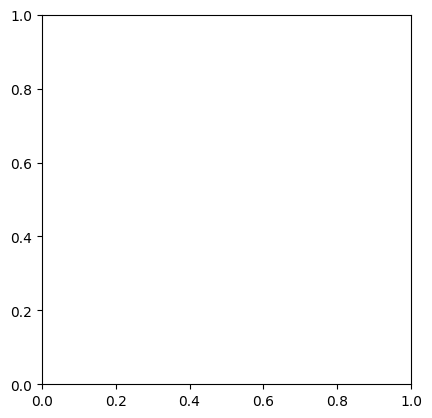

In [6]:
import csv
import matplotlib.pyplot as plt
from matplotlib.path import Path as MplPath
import matplotlib.patches as patches

# Function to parse the segment string and return the coordinates
def parse_segment(segment_str):
    segment_str = segment_str.replace('CubicBezier: start=(', '').replace('Line: start=(', '')
    segment_str = segment_str.replace('control1=(', '').replace('control2=(', '')
    segment_str = segment_str.replace('end=(', '').replace(')', '')
    coords = list(map(float, segment_str.split(',')))
    return coords

# Plotting function
def plot_segments_from_csv(csv_file):
    fig, ax = plt.subplots()
    
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header
        for row in reader:
            segment_str = row[1]
            coords = parse_segment(segment_str)

            if "CubicBezier" in row[1]:
                verts = [(coords[0], coords[1]), (coords[2], coords[3]), (coords[4], coords[5]), (coords[6], coords[7])]
                codes = [MplPath.MOVETO, MplPath.CURVE4, MplPath.CURVE4, MplPath.CURVE4]
            elif "Line" in row[1]:
                verts = [(coords[0], coords[1]), (coords[2], coords[3])]
                codes = [MplPath.MOVETO, MplPath.LINETO]
            else:
                continue
            
            path = MplPath(verts, codes)
            patch = patches.PathPatch(path, edgecolor='black', lw=2, fill=False)
            ax.add_patch(patch)
    
    ax.set_aspect('equal', 'box')
    plt.show()

# Specify your CSV file path here
csv_file = 'output_paths.csv'
plot_segments_from_csv(csv_file)
